# Principal Component Analysis (PCA) with EEG waveforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (15, 5)
%config InlineBackend.figure_format = 'retina'

## <font color=blue>Learning Objectives</font>

1. You will be able to apply PCA to time series.
2. You will be able to classify time series and visualize the classification in a low number of PCs.
3. You will be able to visualize classified time series in higher than three dimensions.
4. You will appreciate how classification of time series waveforms could be beneficial for interpreting experimental data.

## EEG recordings

In [5]:
from scipy.io import loadmat

data = loadmat('eeg.mat')

# grab relevant data, EEG units are microvolts (uV), time is in milliseconds (ms)
# each channel is an electrode, each trial is a separate EEG recording from that electrode
eeg = data["EEG"][0,0]["data"]  # [channel, time, trial]
time = data["EEG"][0,0]["times"][0]

eeg.shape, time.shape

((64, 640, 99), (640,))

### `eeg[channel, time point, trial]`

![EEG data structure](images/eeg_data_structure.png)

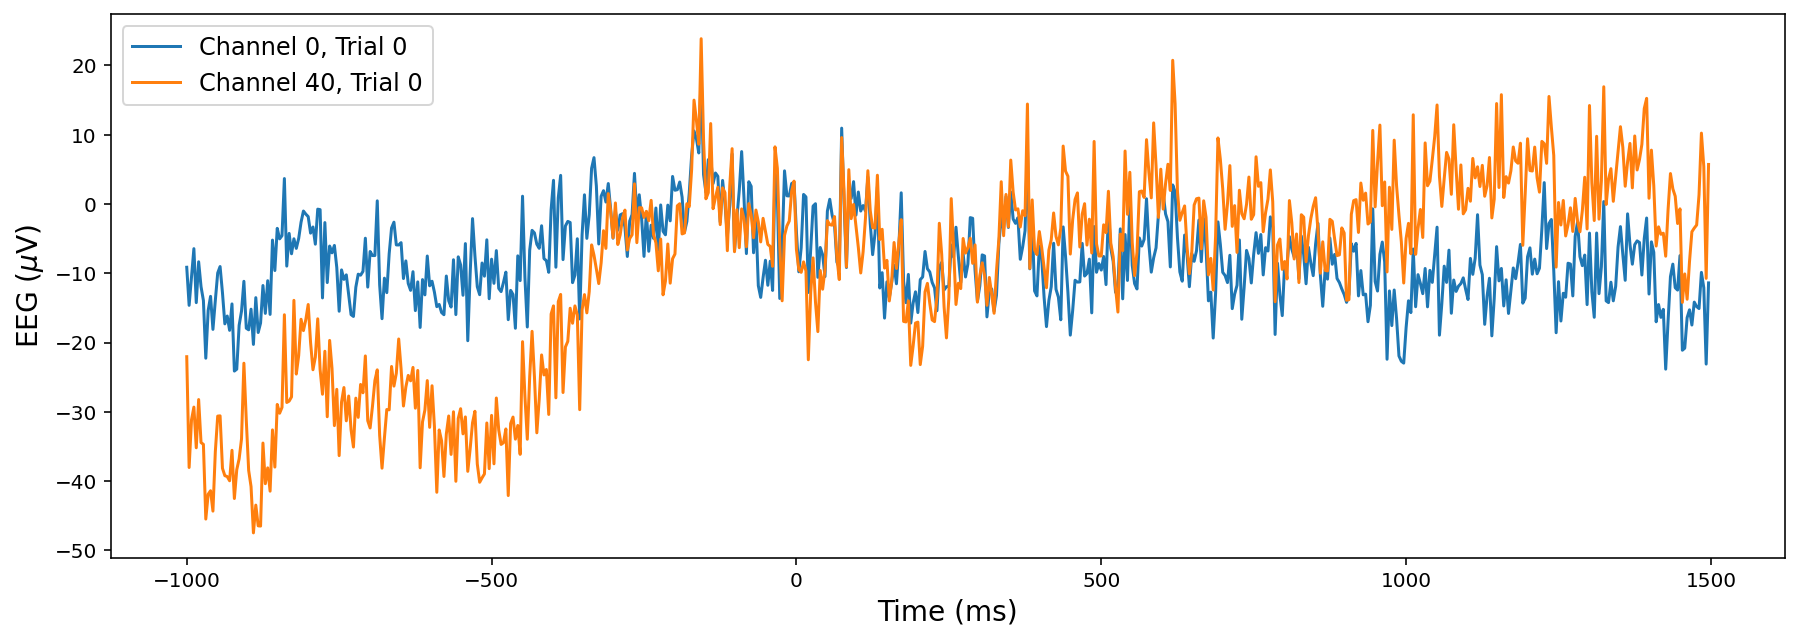

In [6]:
plt.plot(time, eeg[0,:,0], label="Channel 0, Trial 0")
plt.plot(time, eeg[40,:,0], label="Channel 40, Trial 0")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.legend();

### Average EEG across trials in each channel.

### `eegAvg[channel, time point]`

![Average EEG data structure](images/avg_eeg_data_structure.png)

In [7]:
eegAvg = eeg.mean(axis=2)

eegAvg.shape

(64, 640)

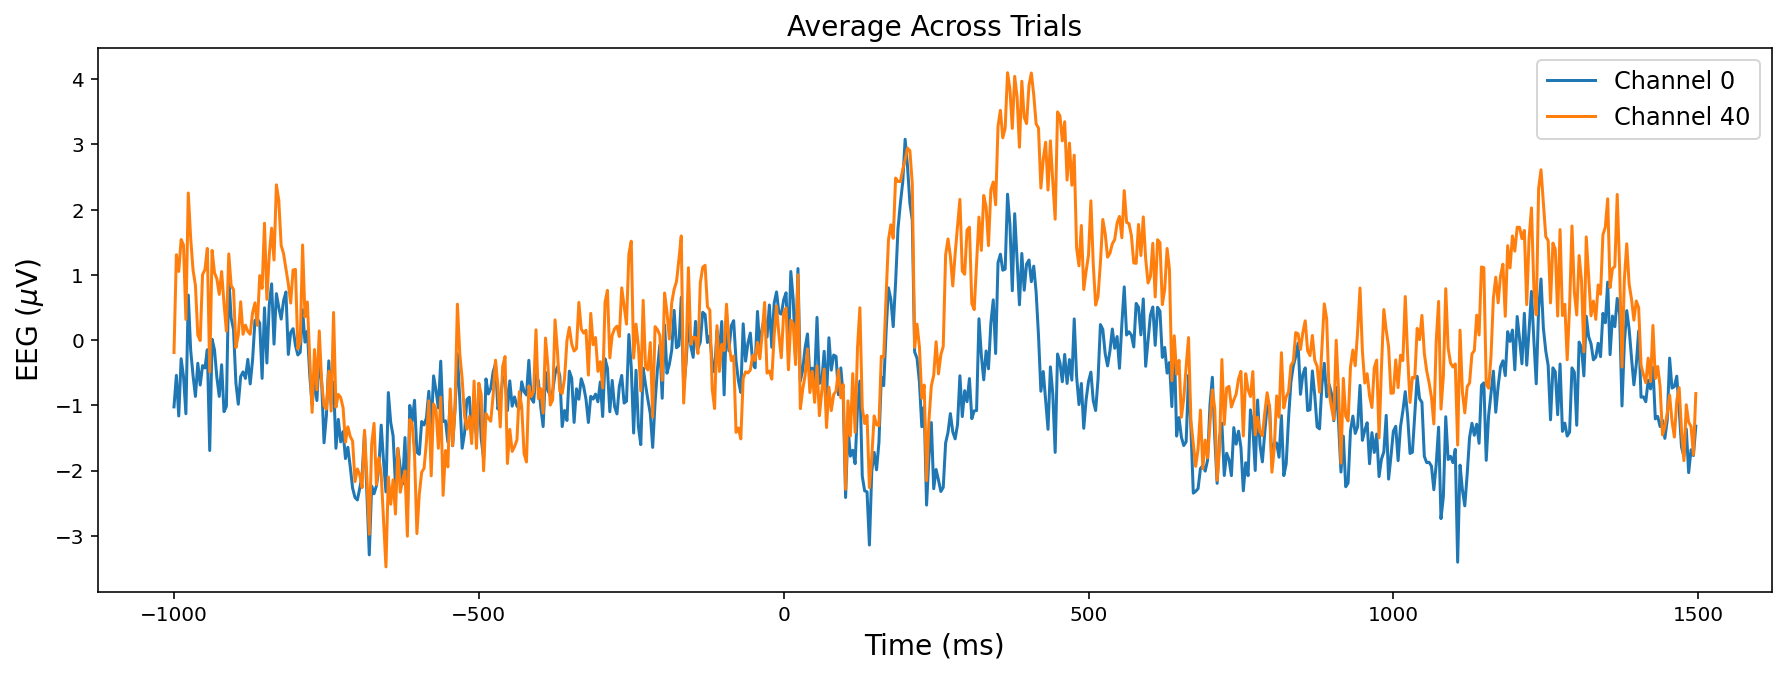

In [8]:
plt.plot(time, eegAvg[0,:], label="Channel 0")
plt.plot(time, eegAvg[40,:], label="Channel 40")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average Across Trials');
plt.legend();

### Each EEG is 640 time points --> a 640-dimensional vector

### We could plot each EEG as a point in a 640-dimensional space

### <font color=red>Should we standardize the EEG data before performing PCA? Why or why not?</font>

Note: Since each time point is a dimension, this would amount to normalizing the variance across EEGs at each time point.

### Can we reasonably explain each 640 sample length EEG with ONLY 3 values instead of 640!?

In [59]:
from sklearn.decomposition import PCA

pca = PCA(3)
pca.fit(eegAvg)

PCA(n_components=3)

### Done! But how do we interpret this?

### The three principal component axes are each a direction in the 640-dimensional coordinate system for the EEGs.

In [60]:
pca.components_.shape

(3, 640)

### The 640-dimensional coordinate system for the EEGs represents the observed EEG amplitude ($\mu V$) at each of the 640 time points.

### The direction of each principal component defines a particular set of relative amplitudes at all 640 time points.

### Thus, each principal component defines a particular EEG waveform shape.

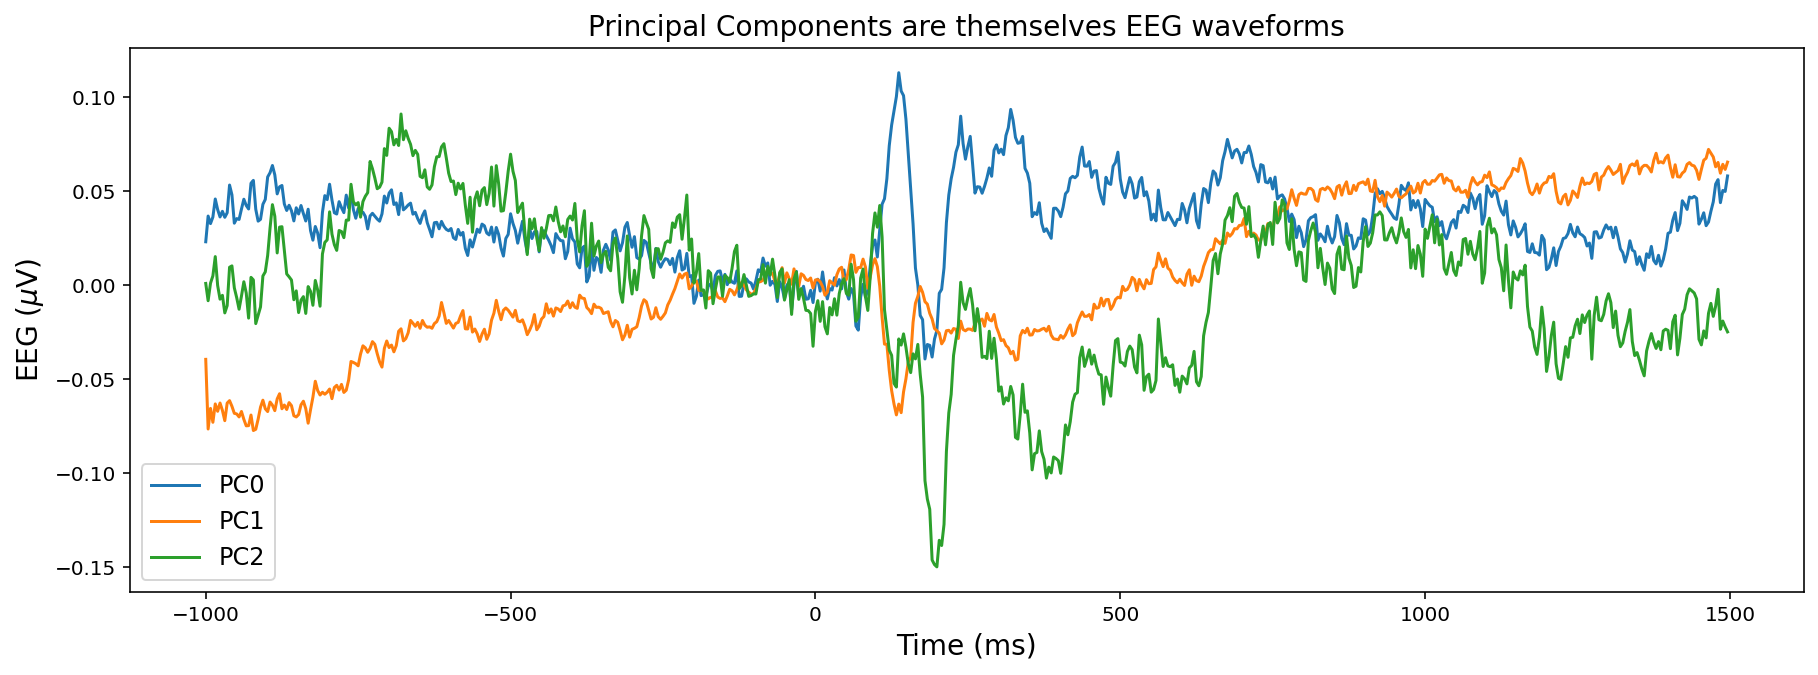

In [61]:
for i in range(3):
    plt.plot(time, pca.components_[i,:], label=f'PC{i}')
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Principal Components are themselves EEG waveforms')
plt.legend();

### So when we describe each 640 sample length EEG with only 3 values, what we are actually doing is describing each EEG as a mixture of the 3 principal component EEG shapes.

In [62]:
eegAvg_mix_of_pc = pca.transform(eegAvg)

eegAvg_mix_of_pc.shape

(64, 3)

In [63]:
eegAvg_mix_of_pc[:5,:]

array([[-50.390007 ,   5.4298086,   9.518045 ],
       [-44.33464  ,  12.796189 ,   6.094214 ],
       [-39.274586 ,  -9.802839 ,   2.4354534],
       [ -8.723723 ,  32.09607  , -19.623272 ],
       [-27.016552 ,   8.502508 ,  -5.04885  ]], dtype=float32)

## Let's see how well a mixture of the 3 principal components can describe the average EEG in channel 0.

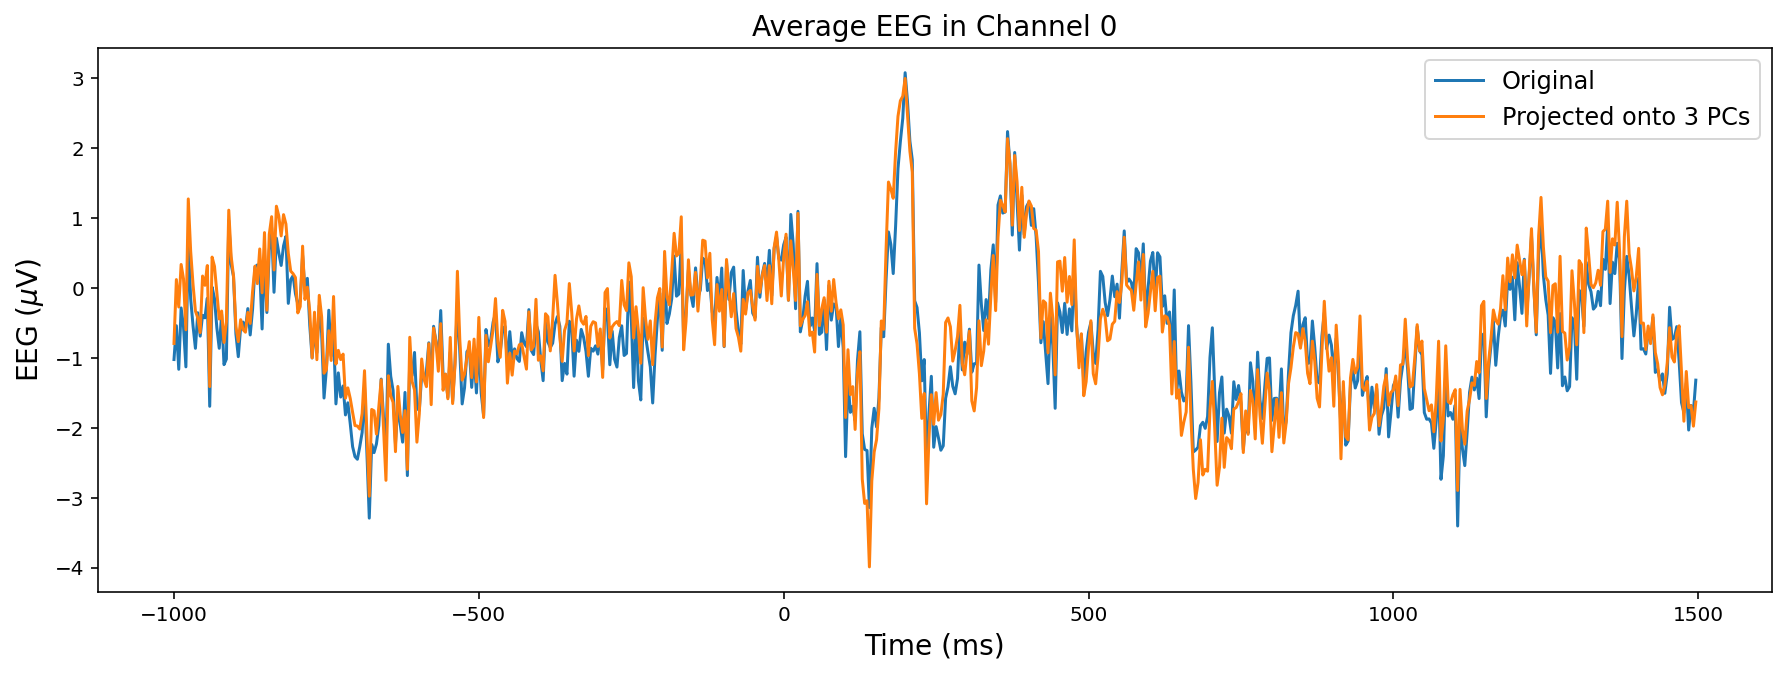

In [66]:
channel0_original = eegAvg[0,:]

# PCA components are relative to the mean across the EEG dataset
channel0_pca = pca.mean_.copy()  # !!! <-- If we don't copy this we'll end up changing pca.mean_
for i in range(3):
    channel0_pca += (eegAvg_mix_of_pc[0,i] * pca.components_[i,:])

plt.plot(time, channel0_original, label="Original")
plt.plot(time, channel0_pca, label="Projected onto 3 PCs")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average EEG in Channel 0');
plt.legend();

### `pca.inverse_transform(eegAvg_mix_of_pc)` does this mixing for us for the entire dataset...

In [68]:
eegAvg_pcaProjected = pca.inverse_transform(eegAvg_mix_of_pc)

eegAvg_pcaProjected.shape

(64, 640)

### Let's see how good it did for channel 9...

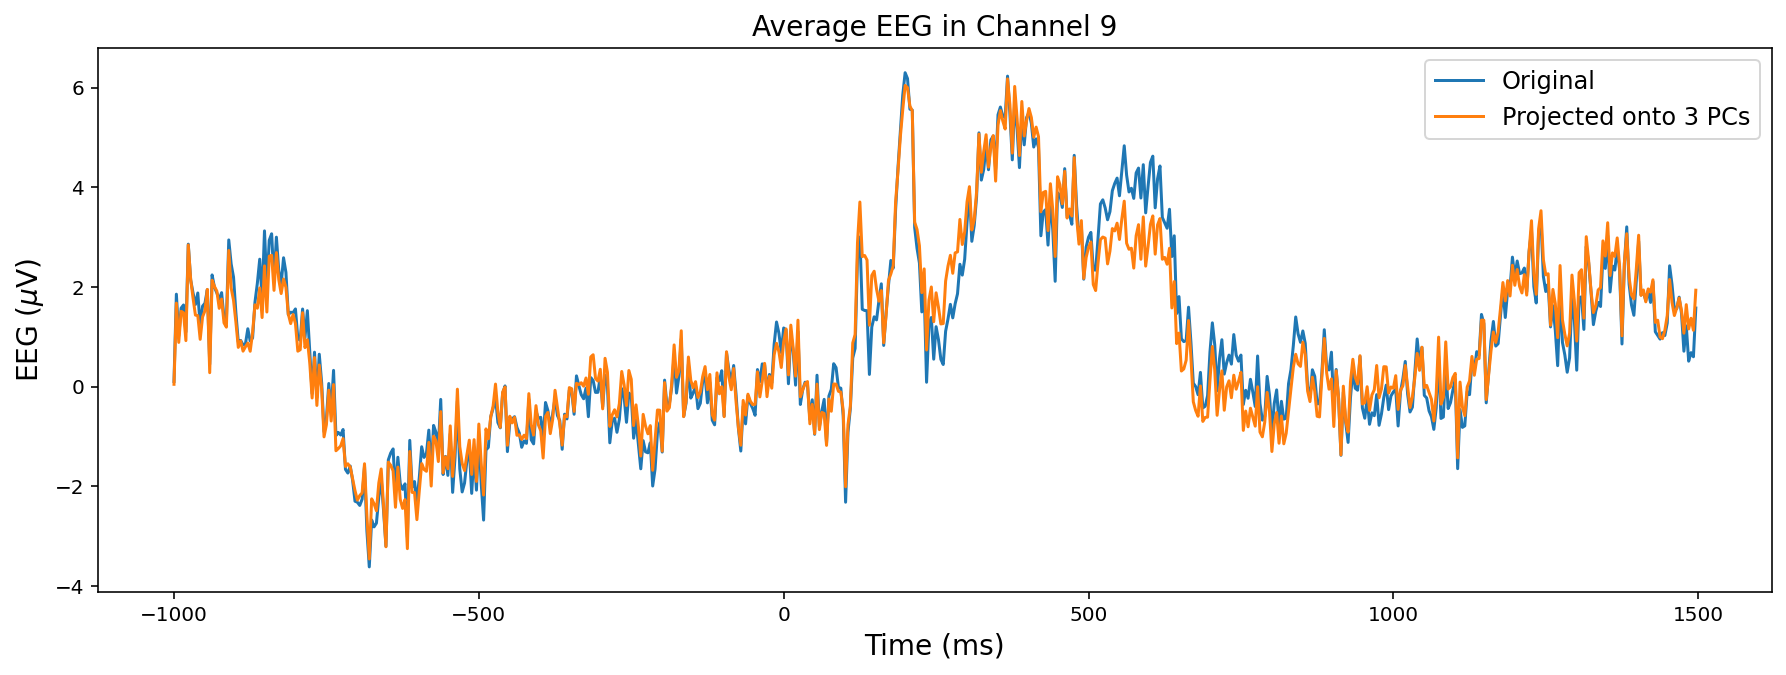

In [69]:
plt.plot(time, eegAvg[9,:], label="Original")
plt.plot(time, eegAvg_pcaProjected[9,:], label="Projected onto 3 PCs")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average EEG in Channel 9');
plt.legend();

### The PCA projected EEGs look like they are a pretty goodd representation of the original EEGs, but there are some differences due to the fact that we threw out the variance along 637 dimensions!

### How much information did we lose? Or conversely, how much do we still explain after projecting each EEG onto only 3 dimensions?

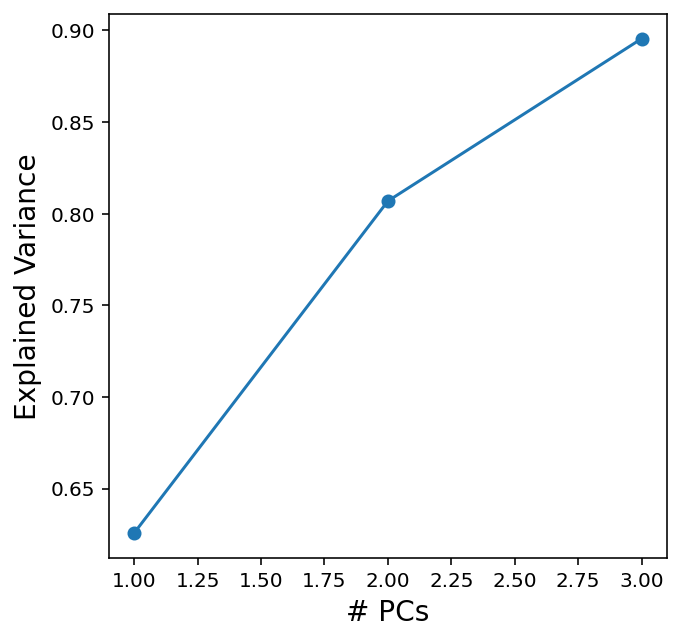

In [71]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(1, 4), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('# PCs')
plt.ylabel('Explained Variance');

### Wow, ~90% of variance explained using ONLY 3 PCs!

### Let's plot all of our 64 EEG waveforms in the projected 3-dimensional PCA space.

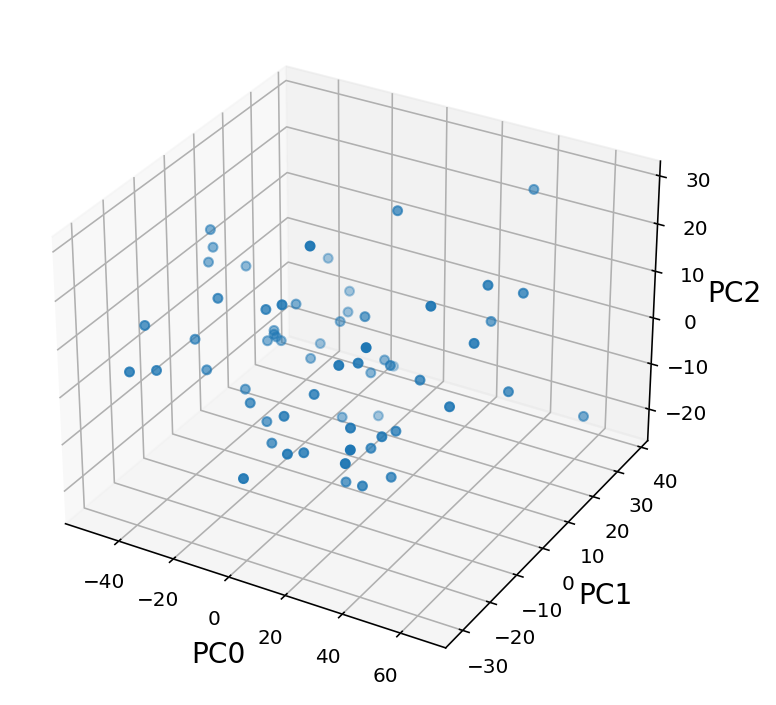

In [72]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(eegAvg_mix_of_pc[:,0], eegAvg_mix_of_pc[:,1], eegAvg_mix_of_pc[:,2])
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

### Let's try clustering these recordings into two groups using $k$-means...

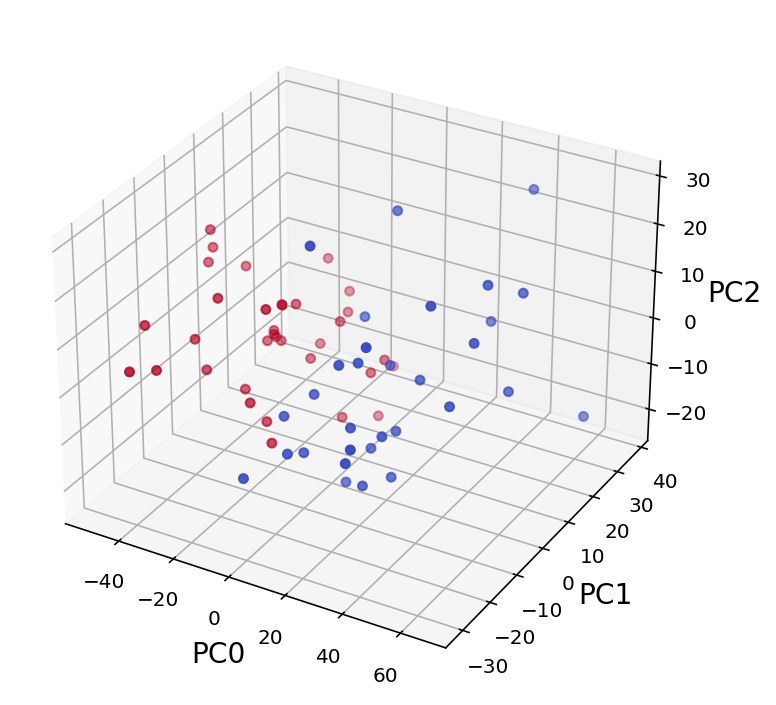

In [74]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(eegAvg_mix_of_pc)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(eegAvg_mix_of_pc[:,0], eegAvg_mix_of_pc[:,1], eegAvg_mix_of_pc[:,2], c=labels, cmap='coolwarm')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

### Do waveforms in each cluster have distinct shapes?

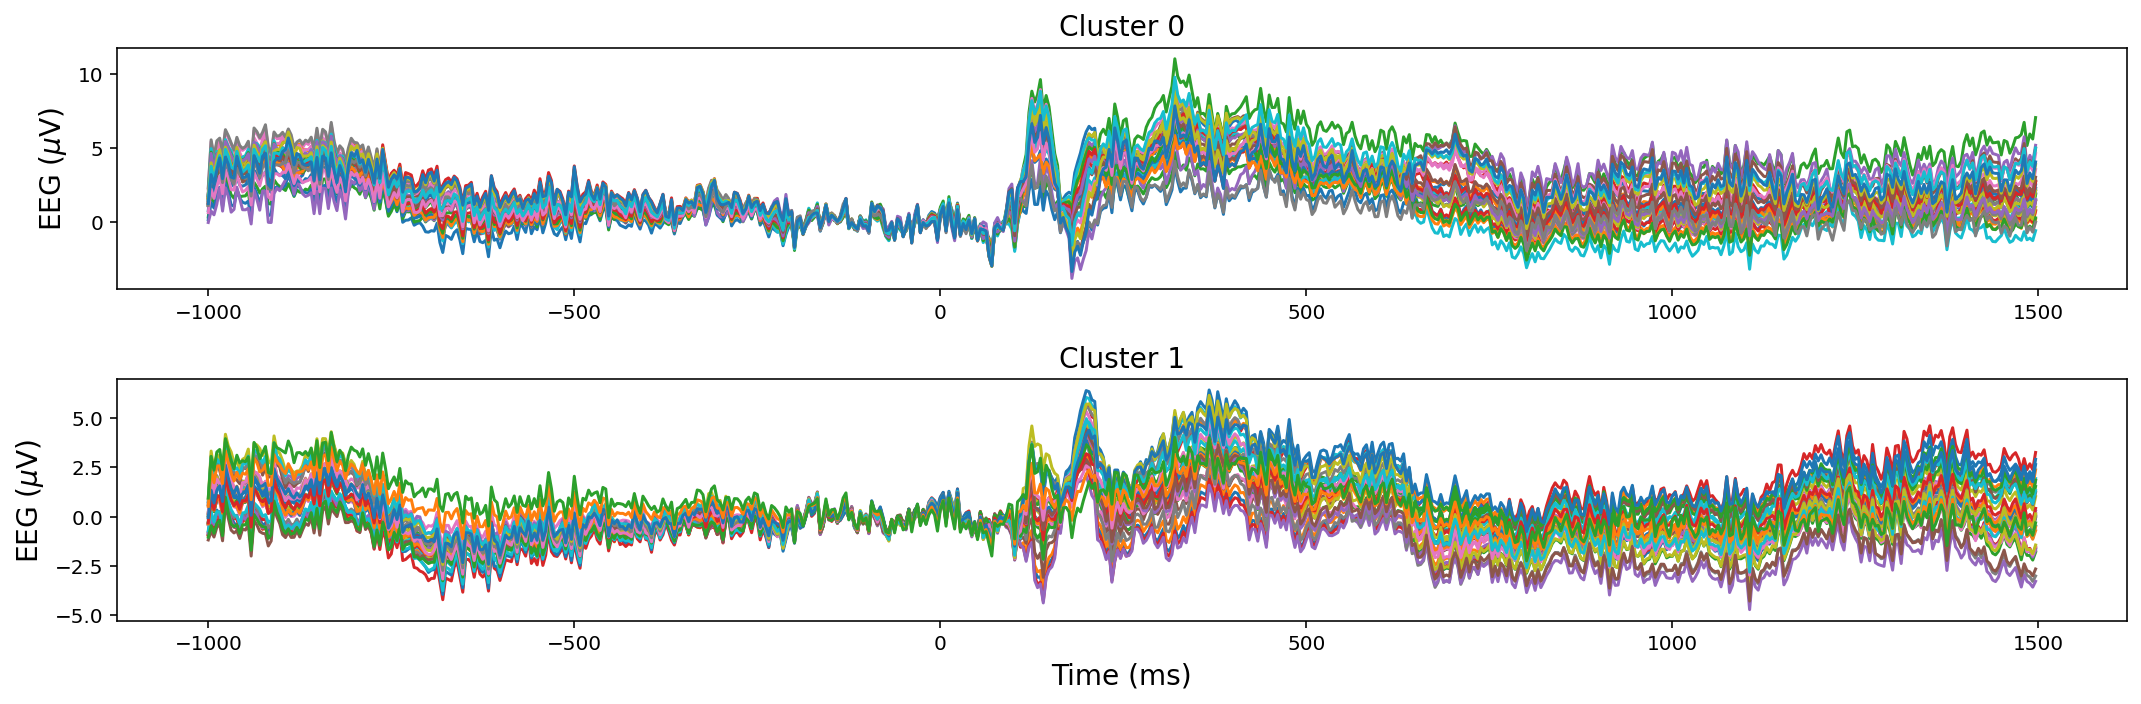

In [87]:
[fig, ax] = plt.subplots(2, 1)
for channel in range(64):
    cluster = labels[channel]
    ax[cluster].plot(time, eegAvg_pcaProjected[channel,:])
ax[0].set_ylabel('EEG ($\mu$V)')
ax[0].set_title('Cluster 0')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('EEG ($\mu$V)')
ax[1].set_title('Cluster 1')
plt.tight_layout();

### Let's try clustering with a GMM and using BIC or AIC to determine the optimal number of clusters...

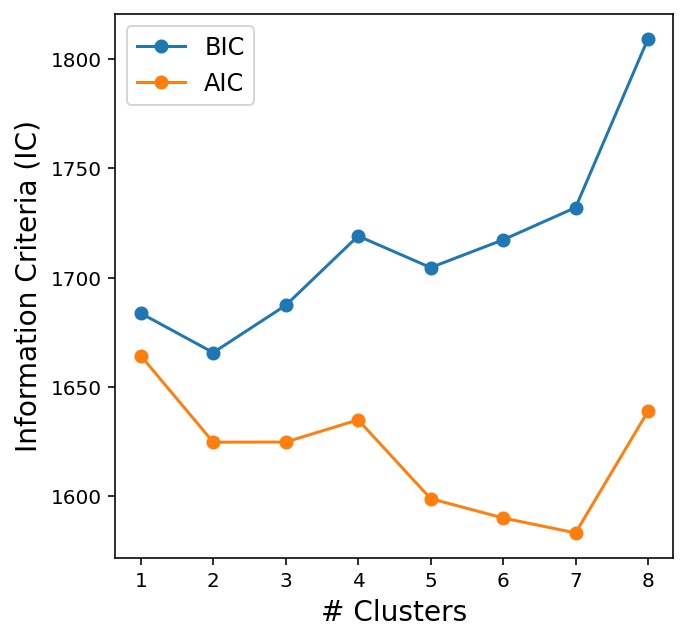

In [89]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 9)
models = [GaussianMixture(n_components=n, random_state=0) for n in n_components]
for model in models:
    model.fit(eegAvg_mix_of_pc)
    
bic = [model.bic(eegAvg_mix_of_pc) for model in models]
aic = [model.aic(eegAvg_mix_of_pc) for model in models]

plt.figure(figsize=(5,5))
plt.plot(n_components, bic, 'o-', label='BIC')
plt.plot(n_components, aic, 'o-', label='AIC')
plt.xlabel('# Clusters');
plt.ylabel('Information Criteria (IC)')
plt.legend();

### Cluster EEGs using a GMM with $n$ components

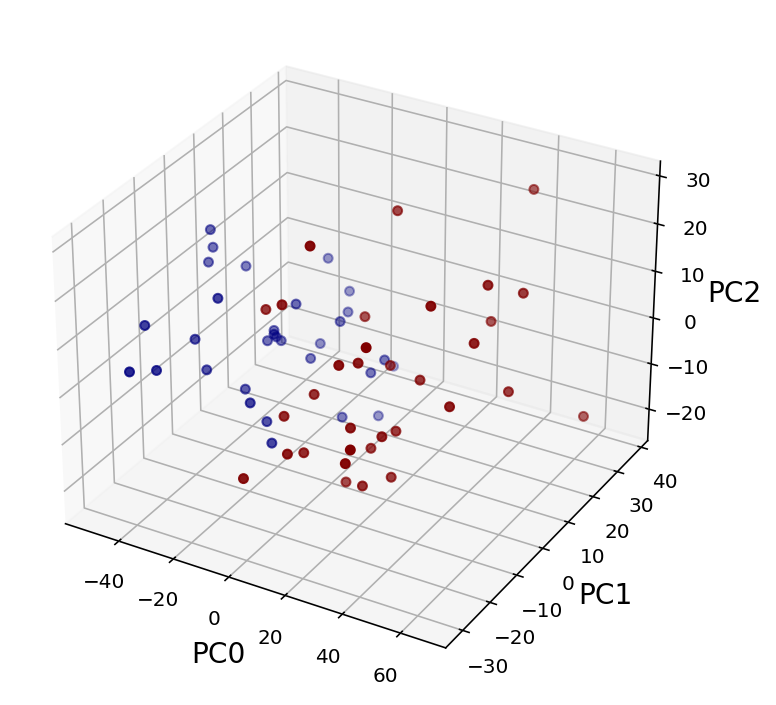

In [118]:
n = 2
gmm = GaussianMixture(n_components=n)
labels = gmm.fit_predict(eegAvg_mix_of_pc)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(eegAvg_mix_of_pc[:,0], eegAvg_mix_of_pc[:,1], eegAvg_mix_of_pc[:,2], c=labels, cmap='jet')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

### Visualize waveforms in each cluster

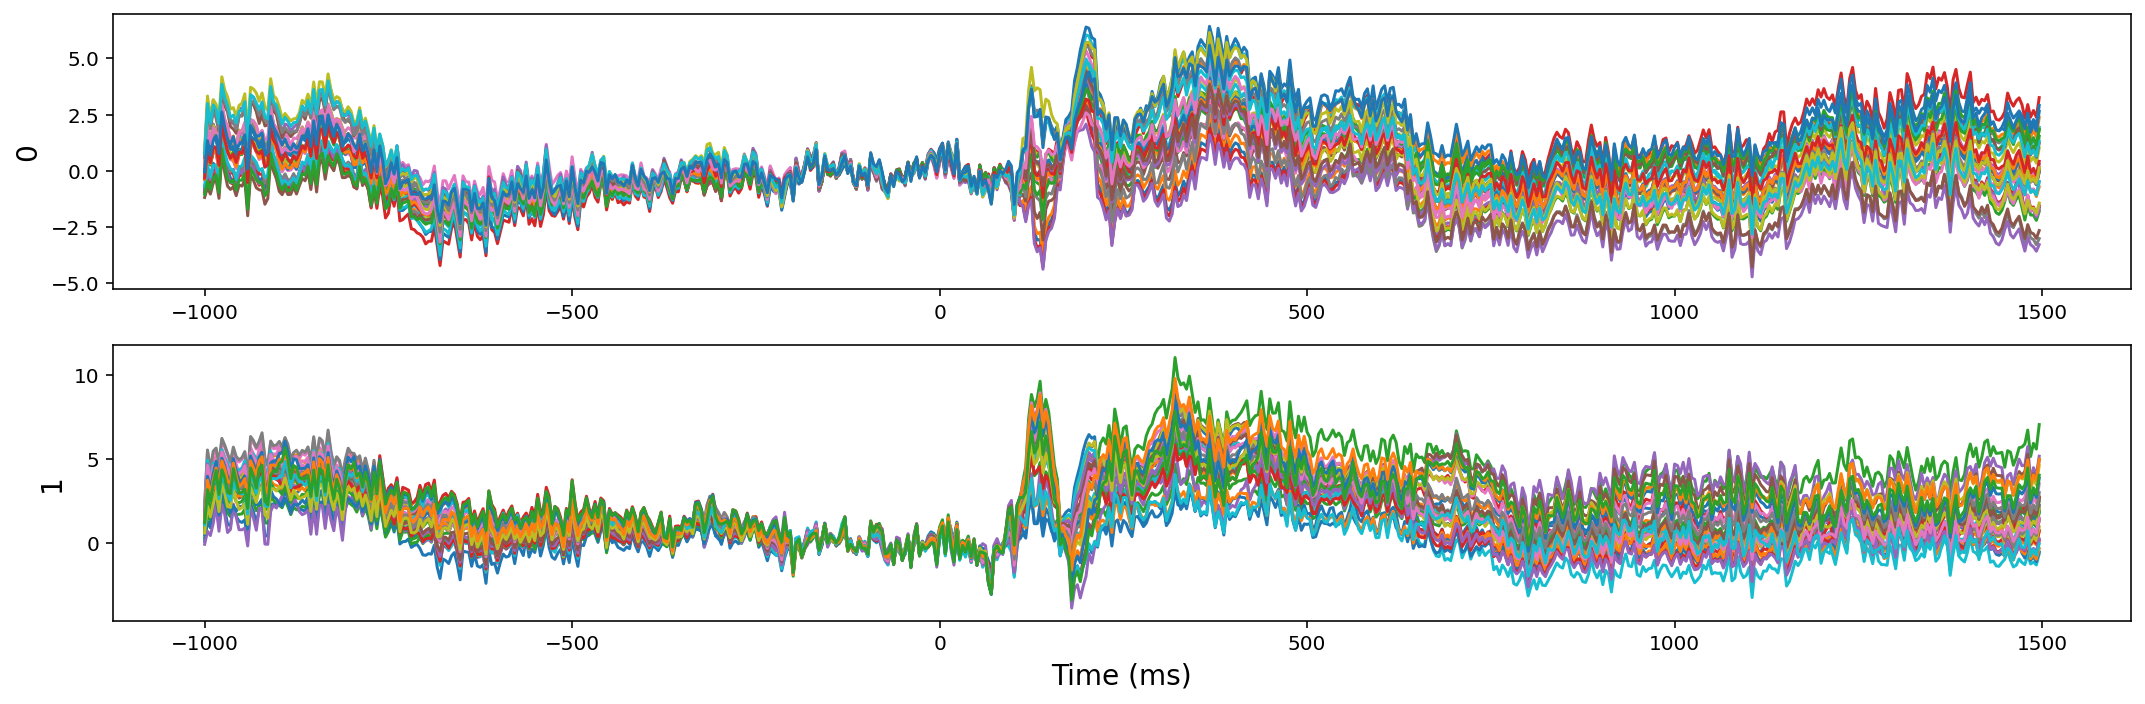

In [119]:
[fig, ax] = plt.subplots(n, 1)
for channel in range(64):
    cluster = labels[channel]
    ax[cluster].plot(time, eegAvg_pcaProjected[channel,:])
for i in range(n):
    ax[i].set_ylabel(i)
ax[-1].set_xlabel('Time (ms)')
plt.tight_layout();

### Try clustering again with $n = 3$ or $n = 7$